In [1]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


(1000, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-22.492028,-22.892028,-23.292028,-23.692028,-24.092028,-24.492028,-24.892028,-25.292028,-25.692028,-26.092028,...,-38.492028,-38.892028,-39.292028,-39.692028,-40.092028,-40.492028,-40.892028,-41.292028,-41.692028,-42.092028
1,-98.975727,-99.375727,-99.775727,-100.175727,-100.575727,-100.975727,-101.375727,-101.775727,-102.175727,-102.575727,...,-114.975727,-115.375727,-115.775727,-116.175727,-116.575727,-116.975727,-117.375727,-117.775727,-118.175727,-118.575727
2,-69.958962,-70.358962,-70.758962,-71.158962,-71.558962,-71.958962,-72.358962,-72.758962,-73.158962,-73.558962,...,-85.958962,-86.358962,-86.758962,-87.158962,-87.558962,-87.958962,-88.358962,-88.758962,-89.158962,-89.558962
3,-80.868001,-81.268001,-81.668001,-82.068001,-82.468001,-82.868001,-83.268001,-83.668001,-84.068001,-84.468001,...,-96.868001,-97.268001,-97.668001,-98.068001,-98.468001,-98.868001,-99.268001,-99.668001,-100.068001,-100.468001
4,-103.160613,-103.560613,-103.960613,-104.360613,-104.760613,-105.160613,-105.560613,-105.960613,-106.360613,-106.760613,...,-119.160613,-119.560613,-119.960613,-120.360613,-120.760613,-121.160613,-121.560613,-121.960613,-122.360613,-122.760613


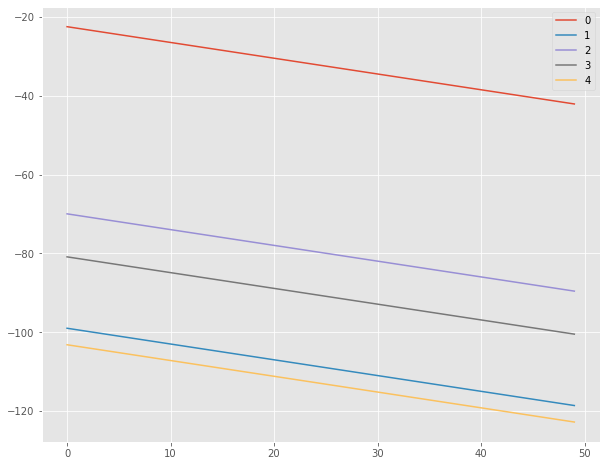

In [2]:
# Function for generating curves with a specified offset
from scipy.stats import gamma
import math
def generate_data(n=20000, x_vals=np.arange(0, 10, .2), max_offset=100, mul_range=[1, 30]):
    #max_offset=100
    vectors = []
    for i in range(n):
        offset = np.random.random() * max_offset
        rv = gamma(offset,scale = np.random.random()/2)
       # mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        mul = np.linspace(mul_range[0], mul_range[1], num=50)
      #  arr = rv.pdf(mul)
        arr = rv.cdf(mul)
        
        
        vectors.append(
             (offset + x_vals)* -2 + 1
#               (offset + x_vals * -mul)** 2 + 1
        )
    return np.array(vectors)

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
n=1000
# Generate 5 random curves using the function above
data=generate_data(n)
print(data.shape)
data0=pd.DataFrame(data)
ax = data0.head().T.plot()
data0.head()

In [3]:
def generator(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[10])
G, G_out = generator(G_in)
G.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 200)               2200      
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


In [4]:
#SVG(model_to_dot(G, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [5]:
# Build the discriminator network 
def discriminator(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[50])
D, D_out = discriminator(D_in)
D.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 50)            300       
_________________________________________________________________
dropout (Dropout)            (None, 46, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2300)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                115050    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102 

In [6]:
#SVG(model_to_dot(D, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable


In [8]:
# Build the final GAN architecture 
def build_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([10])
GAN, GAN_out = build_gan(GAN_in, G, D)
GAN.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
model (Functional)           (None, 50)                12250     
_________________________________________________________________
model_1 (Functional)         (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [9]:


def sample_data_and_gen(G, noise_dim=10, n_samples=n//2):
    random_indices = np.random.choice(n, size=n//2, replace=False)
    #XT = sample_data(n_samples=n_samples)
    XT=data[random_indices,:]
    #print(np.asarray(XT).shape)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
  
    XN = G.predict(XN_noise)
    #print(np.asarray(XN).shape)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

# Pretrain the discriminator network for a single epoch
def pretrain(G, D, noise_dim=10, n_samples=n//2, batch_size=32):
    ep = 1
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=ep, batch_size=batch_size)

pretrain(G, D)

32/32 [==============================] - 2s 13ms/step - loss: 2.6104


In [10]:
def sample_noise(G, noise_dim=10, n_samples=n/2):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

def train(GAN, G, D, epochs=500, n_samples=n//2, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    # initialize loss arrays
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))

        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)


<ipython-input-10-b6b16e80f65d>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  e_range = tqdm(e_range)


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 6.699344158172607, Discriminative Loss: 0.000741034047678113
Epoch #100: Generative Loss: 7.765579700469971, Discriminative Loss: 0.00023281840549316257
Epoch #150: Generative Loss: 8.165346145629883, Discriminative Loss: 0.0001634123473195359
Epoch #200: Generative Loss: 7.72772216796875, Discriminative Loss: 0.00022076748427934945
Epoch #250: Generative Loss: 9.153358459472656, Discriminative Loss: 6.187500548548996e-05
Epoch #300: Generative Loss: 9.291274070739746, Discriminative Loss: 5.3151208703638986e-05
Epoch #350: Generative Loss: 9.53339958190918, Discriminative Loss: 4.135234485147521e-05
Epoch #400: Generative Loss: 9.813222885131836, Discriminative Loss: 6.967249646550044e-05
Epoch #450: Generative Loss: 9.962246894836426, Discriminative Loss: 2.6476771381567232e-05
Epoch #500: Generative Loss: 10.098001480102539, Discriminative Loss: 2.3351401978288777e-05


Text(0, 0.5, 'Loss')

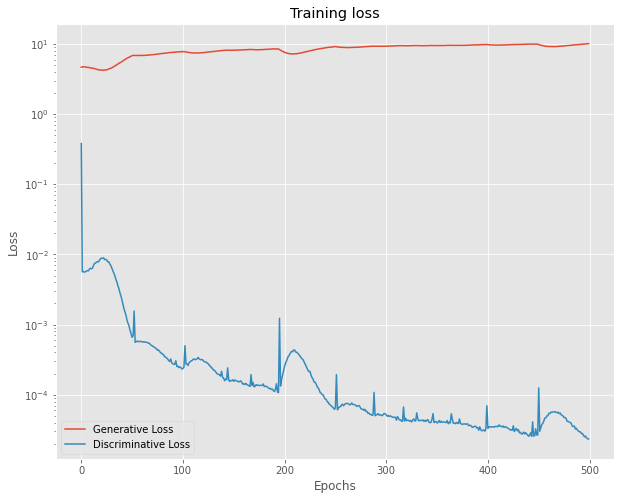

In [11]:
ax = pd.DataFrame({
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }).plot(title='Training loss', logy=True)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

<AxesSubplot:>

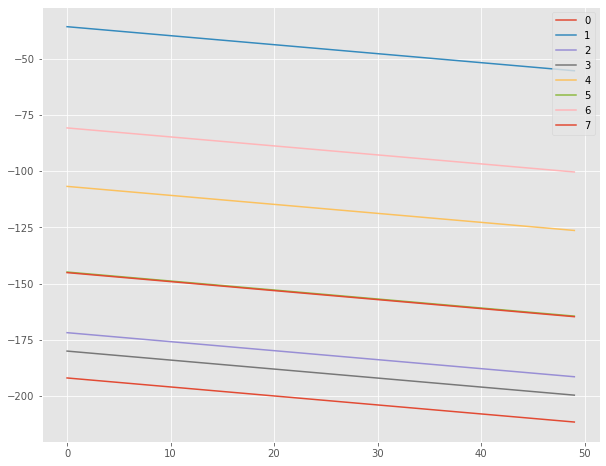

In [12]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:10])).plot()